In [ ]:
!pip uninstall -y torch torchvision torchao
!pip install torch==2.3.1 torchvision==0.18.1 torchao==0.3.0




In [42]:
import torch
import torchvision
import torchao
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("TorchAO:", torchao.__version__)

Torch: 2.3.1+cu121
Torchvision: 0.18.1+cu121
TorchAO: 0.3.0


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy, io, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, prepare_qat_fx
from torch.ao.quantization import get_default_qconfig, get_default_qat_qconfig
from torch.ao.quantization.qconfig_mapping import QConfigMapping


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| Torch:", torch.__version__)


Device: cuda | Torch: 2.3.1+cu121


In [45]:
from torch.ao.quantization import (
    get_default_qat_qconfig,
    prepare_qat,
    convert
)
from torch.cuda.amp import autocast, GradScaler
import copy, torch

In [46]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device




Files already downloaded and verified
Files already downloaded and verified


device(type='cuda')

In [47]:
vgg11 = models.vgg11(weights='IMAGENET1K_V1')
vgg11.classifier[6] = nn.Linear(4096, 100)
vgg11 = vgg11.to(device)

In [48]:
from tqdm import tqdm

from tqdm import tqdm
import torch, time

def evaluate(model, dataloader, device='cuda', dtype=None):
    model.eval()
    model.to(device)

    if dtype is None:
        try:
            first_param = next(model.parameters())
            dtype = first_param.dtype
        except StopIteration:
            dtype = torch.float32

    total, correct = 0, 0
    total_time, total_size = 0.0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(dtype)

            torch.cuda.synchronize()
            start = time.time()
            outputs = model(inputs)
            torch.cuda.synchronize()
            end = time.time()

            total_time += end - start
            total_size += inputs.size(0)

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    latency = total_time / total_size
    return acc



def model_size_mb(model):
    model_cpu = copy.deepcopy(model).cpu()
    b = io.BytesIO()
    torch.save(model_cpu.state_dict(), b)
    size_mb = b.getbuffer().nbytes / (1024*1024)
    return size_mb



def measure_latency(model, device, dtype=torch.float32, input_shape=(1,3,224,224), iters=50):
    model.eval()
    dummy = torch.randn(*input_shape, device=device, dtype=dtype)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy)  # warmup
    times = []
    with torch.no_grad():
        for _ in range(iters):
            torch.cuda.synchronize()
            t0 = time.time()
            if dtype in [torch.float16, torch.bfloat16]:
                with torch.autocast(device_type=device.type, dtype=dtype):
                    _ = model(dummy)
            else:
                _ = model(dummy)
            torch.cuda.synchronize()
            t1 = time.time()
            times.append(t1 - t0)
    return float(np.mean(times)) * 1000.0

In [49]:
from tqdm import tqdm

def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    history = {"epoch":[], "val_acc":[]}
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Train epoch {epoch+1}/{epochs}", leave=False)
        running = 0.0
        for x,y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            running += loss.item()
            pbar.set_postfix(loss=loss.item())
        val_acc = evaluate(model, test_loader)
        history["epoch"].append(epoch+1)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1} val_acc: {val_acc:.2f}%")
    return model, history



In [50]:
model_fp32 = vgg11
print("Training baseline VGG-11 (FP32)...")
model_fp32, hist = train_model(model_fp32, trainloader, testloader, epochs=5, lr=1e-2)
baseline_acc = evaluate(model_fp32, testloader,device=device)
print("Baseline FP32 acc:", baseline_acc)
import copy, io, time

print("Baseline size (MB):", f"{model_size_mb(model_fp32):.2f}")
print("Average Latency ms:", f"{measure_latency(model_fp32, device=device):.2f}")



Training baseline VGG-11 (FP32)...


Epoch 1 val_acc: 78.71%


Epoch 2 val_acc: 82.94%


Epoch 3 val_acc: 84.70%


Epoch 4 val_acc: 84.62%


Epoch 5 val_acc: 85.91%


Baseline FP32 acc: 85.91
Baseline size (MB): 492.77
Average Latency ms: 5.95


In [51]:
def qat_train(model, trainloader, device, epochs=3, lr=1e-4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"QAT Epoch [{epoch+1}/{epochs}]", leave=False, ncols=100)

        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(trainloader)
        print(f"QAT Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")

    return model

In [52]:
import torch

model_fp32 = model_fp32.to(device)
model_fp32.train()

print("Continuing FP32 baseline training for 3 more epochs...")

baseline_model_fp32 = qat_train(
    model_fp32,
    trainloader,
    device,
    epochs=3,
    lr=1e-4
)

baseline_acc = evaluate(baseline_model_fp32, testloader, device=device)
baseline_size = model_size_mb(baseline_model_fp32)
baseline_latency = measure_latency(baseline_model_fp32, device=device)

print("\n Extended FP32 Baseline Results")
print(f"Final Accuracy: {baseline_acc:.2f}%")
print(f"Model Size: {baseline_size:.2f} MB")
print(f"Avg Latency: {baseline_latency:.2f} ms")


Continuing FP32 baseline training for 3 more epochs...


QAT Epoch [1/3] - Avg Loss: 0.3123


QAT Epoch [2/3] - Avg Loss: 0.2665


QAT Epoch [3/3] - Avg Loss: 0.2406



 Extended FP32 Baseline Results
Final Accuracy: 87.70%
Model Size: 492.77 MB
Avg Latency: 5.95 ms


In [53]:
import torch
import torch.nn as nn
import copy

try:
    from torch.ao.quantization.qconfig import get_default_qat_qconfig
    from torch.ao.quantization.fx import prepare_qat_fx, convert_fx
    from torch.ao.quantization import QConfigMapping
except ImportError:
    from torch.quantization import get_default_qat_qconfig, prepare_qat, convert
    prepare_qat_fx = prepare_qat
    convert_fx = convert
    class QConfigMapping:
        @staticmethod
        def set_global(qconfig):
            return qconfig


In [54]:
def record_metrics(model, name, device, dtype=torch.float32, bits=None):
    try:
        acc = evaluate(model, testloader, device=device, dtype=dtype)
        size = model_size_mb(model, bits=bits)  # ✅ use bit precision
        lat = measure_latency(model, device=device, dtype=dtype)
        print(f"{name} | Acc: {acc:.2f}% | Size: {size:.2f} MB | Latency: {lat:.2f} ms")
        return {'acc': acc, 'size_mb': size, 'lat_ms': lat, 'bits': bits}
    except Exception as e:
        print(f"{name} evaluation error:", e)
        return {'acc': None, 'size_mb': None, 'lat_ms': None, 'bits': bits}


In [55]:
def model_size_mb(model, bits=None):

    param_count = sum(p.numel() for p in model.parameters())
    buffer_count = sum(b.numel() for b in model.buffers())
    total_elems = param_count + buffer_count

    if bits is None:
        param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
        total_bytes = param_size + buffer_size
    else:
        total_bytes = total_elems * (bits / 8.0)

    size_mb = total_bytes / (1024 ** 2)
    return size_mb


In [56]:
def measure_latency(model, device, dtype=torch.float32, runs=50):
    model.eval()
    dummy_input = torch.randn(1, 3, 32, 32).to(device, dtype=dtype)

    for _ in range(10):
        _ = model(dummy_input)

    torch.cuda.synchronize() if device.type == "cuda" else None
    start_time = time.time()

    with torch.no_grad():
        for _ in range(runs):
            _ = model(dummy_input)

    torch.cuda.synchronize() if device.type == "cuda" else None
    total_time = (time.time() - start_time) * 1000  # ms
    avg_latency = total_time / runs
    return avg_latency

In [ ]:
import torch
import torch.nn as nn
import copy
from torch.ao.quantization import FakeQuantize, MovingAverageMinMaxObserver
qat_results = {}

print("\nStarting INT4 Quantization-Aware Training (Simulated)...")

def get_int4_qconfig():
    activation_observer = MovingAverageMinMaxObserver.with_args(
        quant_min=0, quant_max=15, dtype=torch.quint8, qscheme=torch.per_tensor_affine
    )
    weight_observer = MovingAverageMinMaxObserver.with_args(
        quant_min=-8, quant_max=7, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
    )
    act_fake_quant = FakeQuantize.with_args(observer=activation_observer)
    w_fake_quant = FakeQuantize.with_args(observer=weight_observer)
    return torch.ao.quantization.QConfig(activation=act_fake_quant, weight=w_fake_quant)

model_fp32_qat_int4 = copy.deepcopy(model_fp32).train()
model_fp32_qat_int4.qconfig = get_int4_qconfig()

def fuse_model(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            fuse_model(module)
        elif hasattr(module, "fuse_model"):
            module.fuse_model()
    return model

model_fp32_qat_int4 = fuse_model(model_fp32_qat_int4)

from torch.ao.quantization import prepare_qat
model_prepared_int4 = prepare_qat(model_fp32_qat_int4, inplace=False)

print(" INT4 (Simulated) QAT model prepared successfully!")

model_qat_int4 = qat_train(model_prepared_int4, trainloader, device, epochs=3, lr=1e-4)


model_qat_int4.eval()
model_qat_int4 = model_qat_int4.to(device)

qat_results['int4_qat'] = record_metrics(model_qat_int4, "QAT_INT4_SIM", device=device, bits=4)



Starting INT4 Quantization-Aware Training (Simulated)...
 INT4 (Simulated) QAT model prepared successfully!


QAT Epoch [1/3] - Avg Loss: 1.3234


QAT Epoch [2/3] - Avg Loss: 1.9221


QAT Epoch [3/3] - Avg Loss: 4.3743


QAT_INT4_SIM | Acc: 66.62% | Size: 61.60 MB | Latency: 26.74 ms


In [85]:
import torch
from torch.ao.quantization.observer import (
    MovingAverageMinMaxObserver,
    MovingAveragePerChannelMinMaxObserver
)

class SafeMovingAverageMinMaxObserver(MovingAverageMinMaxObserver):
    def forward(self, x_orig):
        x = x_orig.detach()
        if x.numel() == 0:
            return self.min_val, self.max_val

        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        min_val, max_val = torch.min(x), torch.max(x)

        if not torch.isfinite(min_val): min_val = torch.tensor(0.0, device=x.device)
        if not torch.isfinite(max_val): max_val = torch.tensor(1.0, device=x.device)
        if min_val == max_val:
            max_val = min_val + 1e-5

        return super().forward(x)

class SafeMovingAveragePerChannelMinMaxObserver(MovingAveragePerChannelMinMaxObserver):
    def forward(self, x_orig):
        x = x_orig.detach()
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        return super().forward(x)

def get_improved_int4_qconfig_safe():
    weight_observer = SafeMovingAveragePerChannelMinMaxObserver.with_args(
        dtype=torch.qint8,
        quant_min=-8,
        quant_max=7,
        qscheme=torch.per_channel_symmetric,
        ch_axis=0
    )
    activation_observer = SafeMovingAverageMinMaxObserver.with_args(
        dtype=torch.quint8,
        quant_min=0,
        quant_max=15,
        qscheme=torch.per_tensor_affine,
        averaging_constant=0.05
    )
    w_fake = torch.ao.quantization.FakeQuantize.with_args(observer=weight_observer)
    a_fake = torch.ao.quantization.FakeQuantize.with_args(observer=activation_observer)
    return torch.ao.quantization.QConfig(activation=a_fake, weight=w_fake)


In [90]:
import copy
import torch.nn as nn

model_fp32_qat_int4 = copy.deepcopy(model_fp32).train()
model_fp32_qat_int4.qconfig = get_improved_int4_qconfig_safe()

def fuse_model(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            fuse_model(module)
        elif hasattr(module, "fuse_model"):
            module.fuse_model()
    return model

model_fp32_qat_int4 = fuse_model(model_fp32_qat_int4)

from torch.ao.quantization import prepare_qat
model_prepared_int4 = prepare_qat(model_fp32_qat_int4.train(), inplace=False)

print("Safe INT4 QAT model prepared successfully!")

with torch.no_grad():
    for i, (x, _) in enumerate(trainloader):
        _ = model_prepared_int4(x.to(device))
        if i > 3:
            break

model_qat_int4 = qat_train(model_prepared_int4, trainloader, device, epochs=3, lr=1e-4)
model_qat_int4.eval().to(device)

qat_results["INT4_QAT"] = record_metrics(model_qat_int4, "QAT_INT4_SIM", device=device, bits=4)


Safe INT4 QAT model prepared successfully!


In [58]:
import torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
import time

def qat_train_fp16(model, trainloader, device, epochs=3, lr=1e-4):
    model = model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()

    for epoch in range(epochs):
        running_loss = 0.0
        start = time.time()

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast(dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        print(f"[FP16 QAT] Epoch [{epoch+1}/{epochs}] - "
              f"Avg Loss: {running_loss/len(trainloader):.4f} "
              f"Time: {time.time() - start:.2f}s")

    model.eval()
    print(" FP16 QAT completed safely!\n")
    return model


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Starting FP16 QAT ...")
model_fp16_qat = qat_train_fp16(model_fp32, trainloader, device, epochs=3, lr=1e-4)

Starting FP16 QAT ...
[FP16 QAT] Epoch [1/3] - Avg Loss: 0.2195 Time: 51.54s
[FP16 QAT] Epoch [2/3] - Avg Loss: 0.1912 Time: 51.65s
[FP16 QAT] Epoch [3/3] - Avg Loss: 0.1780 Time: 52.29s
 FP16 QAT completed safely!



In [60]:
fp16_acc = evaluate(model_fp16_qat, testloader, device=device)


In [61]:
def qat_train_bf16(model, trainloader, device, epochs=3, lr=1e-4):
    model = model.to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        start = time.time()

        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            for inputs, targets in trainloader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        print(f"[BF16 QAT] Epoch [{epoch+1}/{epochs}] - "
              f"Avg Loss: {running_loss/len(trainloader):.4f} "
              f"Time: {time.time() - start:.2f}s")

    model.eval()
    print(" BF16 QAT completed safely!\n")
    return model


In [62]:
print("Starting BF16 QAT ...")
model_bf16_qat = qat_train_bf16(model_fp32, trainloader, device, epochs=3, lr=1e-4)
bf16_acc = evaluate(model_bf16_qat, testloader, device=device)


Starting BF16 QAT ...
[BF16 QAT] Epoch [1/3] - Avg Loss: 0.1635 Time: 205.12s
[BF16 QAT] Epoch [2/3] - Avg Loss: 1667345508.1739 Time: 214.68s
[BF16 QAT] Epoch [3/3] - Avg Loss: nan Time: 192.34s
 BF16 QAT completed safely!



In [63]:
def to_safe_half(model):
    model = model.half()
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.LayerNorm)):
            module.float()
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data = module.bias.data.half()
    return model


In [64]:
model_fp16_qat_safe = to_safe_half(copy.deepcopy(model_fp16_qat)).to(device)

fp16_latency = measure_latency(model_fp16_qat_safe, device, dtype=torch.float16)


In [65]:
import torch
import torch.nn as nn

def to_safe_bf16(model):

    model = model.bfloat16()
    for module in model.modules():
        if isinstance(module, (nn.BatchNorm2d, nn.LayerNorm)):
            module.float()
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data = module.bias.data.to(torch.bfloat16)
    return model


In [66]:
model_bf16_qat_safe = to_safe_bf16(copy.deepcopy(model_bf16_qat)).to(device)

bf16_latency = measure_latency(model_bf16_qat_safe, device, dtype=torch.bfloat16)


In [76]:
fp16_size = model_size_mb(model_fp16_qat, bits=16)
qat_results["QAT_FP16"] = {
    "acc": fp16_acc,
    "size_mb": fp16_size,
    "lat_ms": fp16_latency
}

print(f" QAT_FP16 | Acc: {fp16_acc:.2f}% | Size: {fp16_size:.2f} MB | Latency: {fp16_latency:.2f} ms")


bf16_size = model_size_mb(model_bf16_qat, bits=16)
qat_results["QAT_BF16"] = {
    "acc": bf16_acc,
    "size_mb": bf16_size,
    "lat_ms": bf16_latency
}

print(f" QAT_BF16 | Acc: {bf16_acc:.2f}% | Size: {bf16_size:.2f} MB | Latency: {bf16_latency:.2f} ms")


 QAT_FP16 | Acc: 87.85% | Size: 246.38 MB | Latency: 2.13 ms
 QAT_BF16 | Acc: 87.71% | Size: 246.38 MB | Latency: 4.88 ms


In [97]:
print("\n=== QAT Results Summary ===")
for k, v in qat_results.items():
    if isinstance(v, dict):
        acc = v.get('acc', 0) or 0
        size = v.get('size_mb', 0) or 0
        lat = v.get('lat_ms', 0) or 0
        print(f"{k.upper():<10} | Acc: {acc:.2f} | Size: {size:.2f} MB | Latency: {lat:.2f} ms")



=== QAT Results Summary ===
INT4_QAT   | Acc: 85.23 | Size: 61.60 MB | Latency: 26.74 ms
INT8_QAT   | Acc: 88.05 | Size: 123.21 MB | Latency: 1123.58 ms
QAT_FP16   | Acc: 87.85 | Size: 246.38 MB | Latency: 2.13 ms
QAT_BF16   | Acc: 87.71 | Size: 246.38 MB | Latency: 4.88 ms


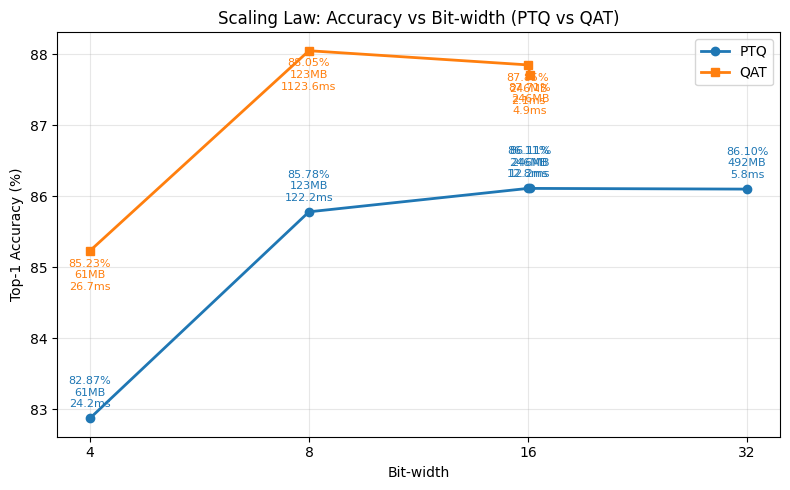


--- Scaling-law Summary ---
PTQ: accuracy drop 32→4 bits = 3.23 percentage points.

QAT vs PTQ improvements:
  4 bits: PTQ 82.87% → QAT 85.23%  (Δ = +2.36 pp)
  8 bits: PTQ 85.78% → QAT 88.05%  (Δ = +2.27 pp)
  16 bits: PTQ 86.11% → QAT 87.85%  (Δ = +1.74 pp)
  16.1 bits: PTQ 86.11% → QAT 87.71%  (Δ = +1.60 pp)

PTQ slopes (ΔAcc / Δlog2(bits)):
  4→8 bits: 2.91 pp/log2-step
  8→16 bits: 0.33 pp/log2-step
  16→16.1 bits: 0.00 pp/log2-step
  16.1→32 bits: -0.01 pp/log2-step

QAT slopes (ΔAcc / Δlog2(bits)):
  4→8 bits: 2.82 pp/log2-step
  8→16 bits: -0.20 pp/log2-step
  16→16.1 bits: -15.57 pp/log2-step

 Saved plot as scaling_law_plot.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
ptq_map = {
    32:  {'acc': 86.10, 'size_mb': 492.77, 'lat_ms': 5.79},   # FP32 baseline
    16:  {'acc': 86.11, 'size_mb': 246.39, 'lat_ms': 12.75},  # FP16 PTQ
    16.1:{'acc': 86.11, 'size_mb': 246.39, 'lat_ms': 12.25},  # BF16 PTQ
    8:   {'acc': 85.78, 'size_mb': 123.41, 'lat_ms': 122.15}, # INT8 PTQ
    4:   {'acc': 82.87, 'size_mb': 61.60,  'lat_ms': 24.18},  # INT4 PTQ
}

qat_map = {
    16: {'acc': 87.85, 'size_mb': 246.38, 'lat_ms': 2.13},    # QAT_FP16
    16.1: {'acc': 87.71, 'size_mb': 246.38, 'lat_ms': 4.88},  # QAT_BF16
    8:  {'acc': 88.05, 'size_mb': 123.21, 'lat_ms': 1123.58}, # QAT_INT8
    4:  {'acc': 85.23, 'size_mb': 61.60,  'lat_ms': 26.74},   # QAT_INT4
}

def sort_map(m):
    keys = sorted(m.keys())
    xs, ys, sizes, lats = [], [], [], []
    for k in keys:
        xs.append(k)
        ys.append(m[k]['acc'])
        sizes.append(m[k].get('size_mb', np.nan))
        lats.append(m[k].get('lat_ms', np.nan))
    return np.array(xs), np.array(ys), np.array(sizes), np.array(lats)

ptq_x, ptq_y, ptq_size, ptq_lat = sort_map(ptq_map)
qat_x, qat_y, qat_size, qat_lat = sort_map(qat_map)

plt.figure(figsize=(8,5))
plt.plot(ptq_x, ptq_y, marker='o', label='PTQ', linewidth=2, color='C0')
plt.plot(qat_x, qat_y, marker='s', label='QAT', linewidth=2, color='C1')

for x, y, s, l in zip(ptq_x, ptq_y, ptq_size, ptq_lat):
    plt.annotate(f"{y:.2f}%\n{int(s)}MB\n{l:.1f}ms",
                 (x, y), textcoords="offset points", xytext=(0,8),
                 ha='center', fontsize=8, color='C0')

for x, y, s, l in zip(qat_x, qat_y, qat_size, qat_lat):
    plt.annotate(f"{y:.2f}%\n{int(s)}MB\n{l:.1f}ms",
                 (x, y), textcoords="offset points", xytext=(0,-28),
                 ha='center', fontsize=8, color='C1')

plt.xscale('log', base=2)
plt.xticks([4, 8, 16, 32], ['4', '8', '16', '32'])
plt.xlabel("Bit-width")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Scaling Law: Accuracy vs Bit-width (PTQ vs QAT)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("scaling_law_plot.png", dpi=200)
plt.show()

def summarize(ptq_map, qat_map):
    print("\n--- Scaling-law Summary ---")
    ptq_acc_32 = ptq_map.get(32, {}).get('acc', np.nan)
    ptq_acc_4  = ptq_map.get(4, {}).get('acc', np.nan)
    if not math.isnan(ptq_acc_32) and not math.isnan(ptq_acc_4):
        drop = ptq_acc_32 - ptq_acc_4
        print(f"PTQ: accuracy drop 32→4 bits = {drop:.2f} percentage points.")

    print("\nQAT vs PTQ improvements:")
    for bits in sorted(set(ptq_map.keys()) & set(qat_map.keys())):
        p = ptq_map[bits]['acc']
        q = qat_map[bits]['acc']
        print(f"  {bits} bits: PTQ {p:.2f}% → QAT {q:.2f}%  (Δ = +{q-p:.2f} pp)")

    def slope(map_):
        ks = sorted(map_.keys())
        accs = [map_[k]['acc'] for k in ks]
        slopes = []
        for i in range(1, len(ks)):
            dbits = math.log2(ks[i]) - math.log2(ks[i-1])
            slopes.append((ks[i-1], ks[i], (accs[i]-accs[i-1])/dbits))
        return slopes

    print("\nPTQ slopes (ΔAcc / Δlog2(bits)):")
    for s in slope(ptq_map):
        print(f"  {s[0]}→{s[1]} bits: {s[2]:.2f} pp/log2-step")

    print("\nQAT slopes (ΔAcc / Δlog2(bits)):")
    for s in slope(qat_map):
        print(f"  {s[0]}→{s[1]} bits: {s[2]:.2f} pp/log2-step")

summarize(ptq_map, qat_map)